In [2]:
import overpass

In [3]:
api=overpass.API()

In [4]:
# we're looking for restaurants within 1000m of a given point

overpass_query = """
(node["amenity"="restaurant"](around:1000,43.66, -79.39);
 way["amenity"="restaurant"](around:1000,43.66, -79.39);
 rel["amenity"="restaurant"](around:1000,43.66, -79.39);
);
out center;
"""

restaurants = api.get(overpass_query)

In [5]:
import plotly.graph_objects as obj

In [6]:
# Extract the lon, lat and name of each restaurant:
coords = []
text = []
for elem in restaurants['features']:
    latlon = elem['geometry']['coordinates']
    if latlon == []: continue
    coords.append(latlon)
    if 'name'  not in elem['properties']:
        text.append('NONAME')
    else:
        text.append(elem['properties']['name'])
        
# Convert into a dictionary for plotly
restaurant_dict = dict(type='scattermapbox',
                   lat=[x[1] for x in coords], 
                   lon=[x[0] for x in coords],
                   mode='markers',
                   text=text,
                   marker=dict(size=8, color='blue'),
                   hoverinfo='text',    
                   showlegend=False)


# plotting restaurants' locations around University of Toronto
center=(43.662643, -79.395689) # UofT main building

fig = obj.Figure(obj.Scattermapbox(restaurant_dict))

# defining plot layout
fig.update_layout(mapbox_style="stamen-terrain")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, mapbox = {'center': {'lat': center[0], 'lon': center[1]}, 'zoom': 13})
fig.show()

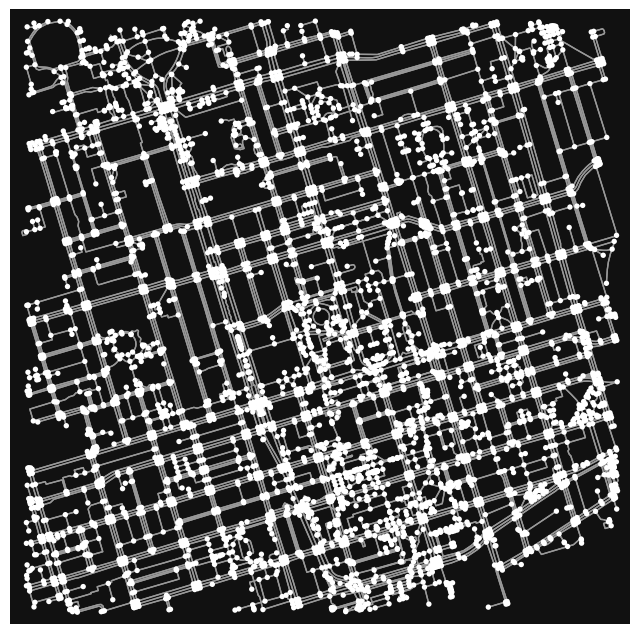

In [7]:
import osmnx as ox
import matplotlib.pyplot as plt

place_name = "Old Toronto, Toronto"

# fetch OSM street network (drive, walk, private, etc.) from the location
graph = ox.graph_from_address(place_name, network_type='walk')
fig, ax = ox.plot_graph(graph)

In [8]:
nodes, edges = ox.graph_to_gdfs(graph)

In [9]:
print(edges['highway'].value_counts())

highway
footway                        9192
service                        1662
secondary                      1106
residential                     844
tertiary                        648
[footway, steps]                552
unclassified                    204
steps                           170
primary                          96
secondary_link                   52
corridor                         24
pedestrian                       24
living_street                    18
[footway, service]               14
[footway, corridor]              12
path                             12
[residential, service]            8
[pedestrian, residential]         2
[service, living_street]          2
[pedestrian, unclassified]        2
[unclassified, residential]       2
[pedestrian, footway]             2
[footway, corridor, steps]        2
Name: count, dtype: int64


In [10]:
ox.basic_stats(graph)


{'n': 4716,
 'm': 14650,
 'k_avg': 6.212892281594572,
 'edge_length_total': 453713.7640000007,
 'edge_length_avg': 30.97022279863486,
 'streets_per_node_avg': 3.1586089906700594,
 'streets_per_node_counts': {0: 0, 1: 511, 2: 0, 3: 2459, 4: 1722, 5: 24},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.10835453774385072,
  2: 0.0,
  3: 0.5214164546225615,
  4: 0.3651399491094148,
  5: 0.005089058524173028},
 'intersection_count': 4205,
 'street_length_total': 226856.8820000004,
 'street_segment_count': 7325,
 'street_length_avg': 30.970222798634865,
 'circuity_avg': 1.0288453035543013,
 'self_loop_proportion': 0.0006825938566552901}

In [11]:
import folium

# Financial District, Toronto, ON
source_point = (43.6479, -79.3818) 

# Yonge-Dundas Square
center=(43.6561, -79.3802)   

# University of Toronto
destination_point = (43.6634, -79.3960) 

m = folium.Map(location=center, zoom_start=15, scrollWheelZoom=False, dragging=False)
folium.Marker(location=source_point,icon=folium.Icon(color='red',icon='camera', prefix='fa')).add_to(m)
folium.Marker(location=center,icon=folium.Icon(color='blue',icon='fa-shopping-cart', prefix='fa')).add_to(m)
folium.Marker(location=destination_point,icon=folium.Icon(color='green',icon='graduation-cap', prefix='fa')).add_to(m)

In [14]:
import geopandas as gpd
import networkx as nx

In [16]:
X = [source_point[1], destination_point[1]]
Y = [source_point[0], destination_point[0]]
closest_nodes = ox.distance.nearest_nodes(graph,X,Y)

# Get the rows from the Node GeoDataFrame
closest_rows = nodes.loc[closest_nodes]

# Put the two nodes into a GeoDataFrame
od_nodes = geopandas.GeoDataFrame(closest_rows, geometry='geometry', crs=nodes.crs)

shortest_route = networkx.shortest_path(G=graph,source=closest_nodes[0],target=closest_nodes[1], weight='length')
print(shortest_route)

[3329398430, 3698533589, 3329398431, 3709678078, 784790085, 3709678082, 6721473575, 3376599900, 3559450479, 3559450476, 780797514, 391167911, 2401060261, 469107104, 394490741, 469107099, 547531033, 394490740, 394497151, 394497152, 10579085120, 394497156, 394497154, 394497155, 4061861176, 393546109, 393546107, 393546115, 2401060401, 393546105, 2449693542, 769486911, 7917610367, 2304485456, 393552049, 393546103, 393551257, 3712907649, 700645269, 393546101, 700645272, 393551210, 393551204, 1470547066, 393546099, 1470547067, 2480722092, 8715035551, 8715035555, 2480731339, 2480731350, 2480731364, 393546092, 393546090, 389677934, 389677937, 60052050, 60052038, 9295001674, 60052037, 2480713275, 60052040, 2129327701, 2557544304, 60052042, 9295001725, 1840221676, 9135892695, 783622470, 389678139, 389678138, 3707407638, 11483951843, 6028561921, 389678124, 7153999189, 1258707990, 11454143368, 7311083158, 1258707987, 2143485199]


In [19]:
from optalgotools import routing

routing.draw_route(graph, shortest_route)

C:\Users\Ananya Pal\AppData\Local\Temp\ipykernel_26956\222311934.py:2: FutureWarning:

The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release.



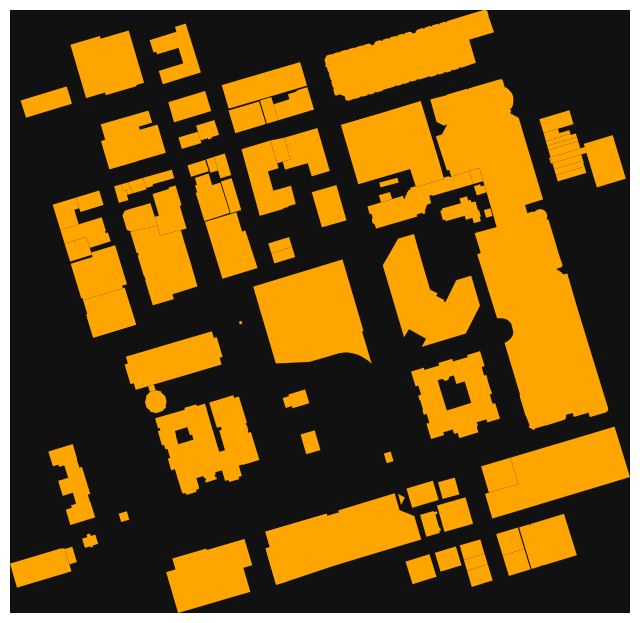

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [20]:
# Retrieve the building footprint, project it to match our previous graph, and plot it.
buildings = ox.geometries.geometries_from_address(place_name, tags={'building':True}, dist=300)
buildings = buildings.to_crs(edges.crs)
ox.plot_footprints(buildings)

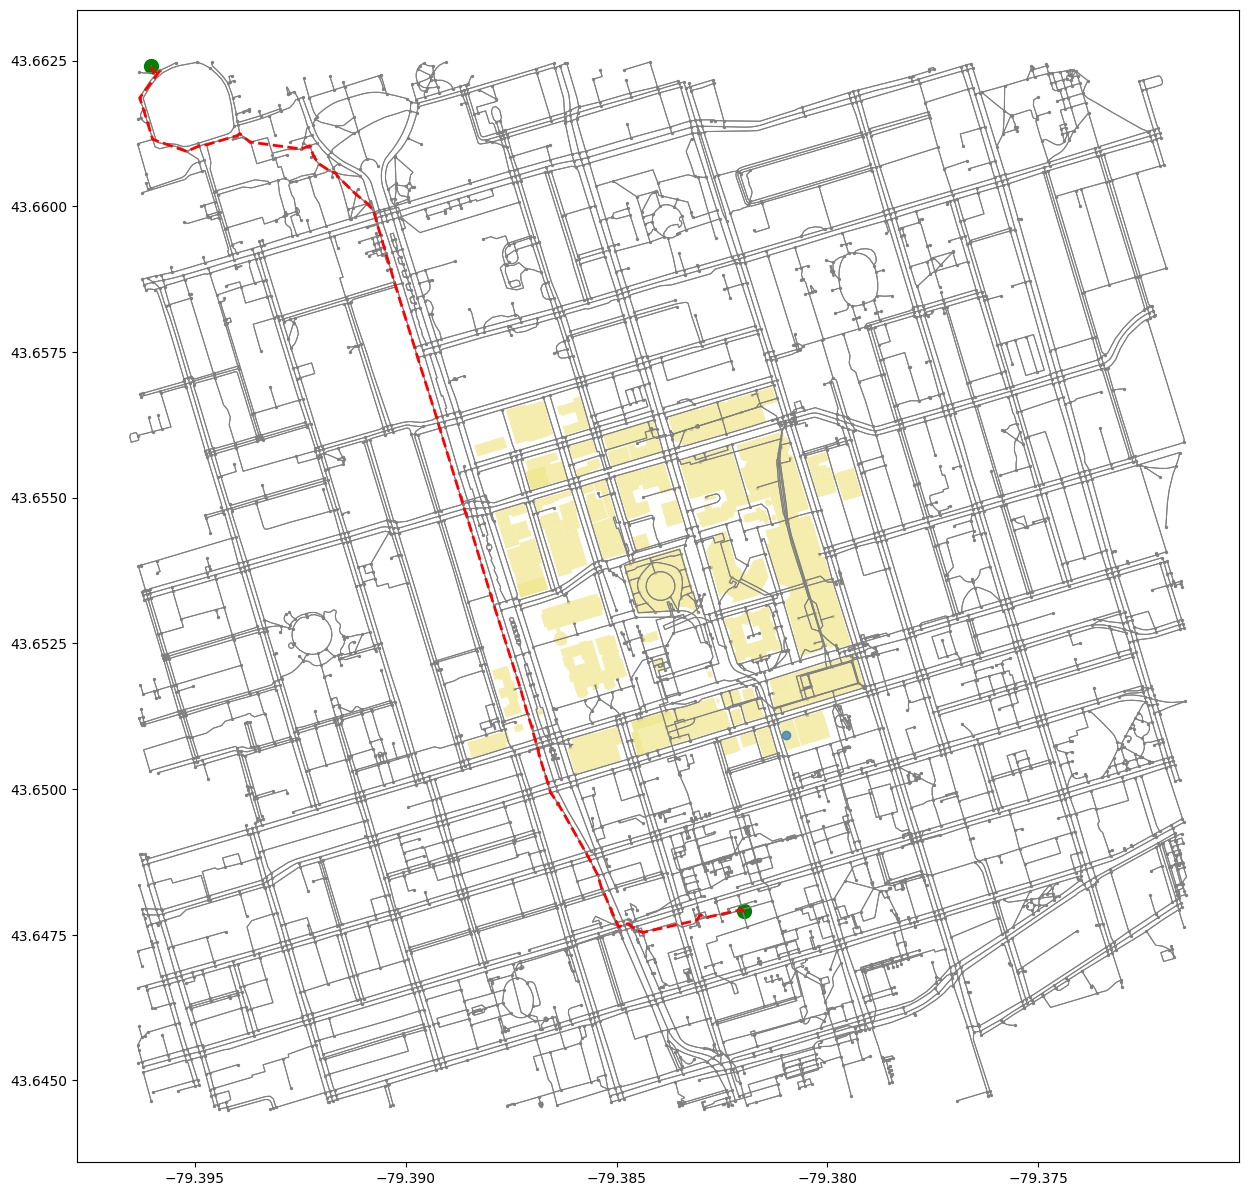

In [21]:
from shapely.geometry import LineString

# Nodes of our shortest path
route_nodes = nodes.loc[shortest_route]

# Convert the nodes into a line geometry
route_line = LineString(list(route_nodes.geometry.values))

# Create a GeoDataFrame from the line
route_geom = geopandas.GeoDataFrame([[route_line]], geometry='geometry', crs=edges.crs, columns=['geometry'])

# Plot edges and nodes
ax = edges.plot(linewidth=0.75, color='gray', figsize=(15,15))
ax = nodes.plot(ax=ax, markersize=2, color='gray')

# Add building footprints
ax = buildings.plot(ax=ax, facecolor='khaki', alpha=0.7)

# Add the shortest route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Highlight the starting and ending nodes
ax = od_nodes.plot(ax=ax, markersize=100, color='green')

In [22]:
#Getting data from open repositories

In [23]:
import requests
import json
import matplotlib.pyplot as plt
import folium

In [28]:
#URL of a sample Bike Share dataset file

url = 'https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information'

#Fetch the contents of the URL
response= requests.get(url)

#Extract the JSON content from the response
json_data = response.json()

# Extract the station informations
stations = json_data.get("data", {}).get("stations", [])
extracted_data = []
for station in stations:
  extracted_data.append({"station_id": station.get("station_id"), "name": station.get("name"), "lat": station.get("lat"), "lon": station.get("lon"), "address": station.get("address"), "capacity": station.get("capacity")})

# Create a folium map centered around Toronto
toronto_map = folium.Map(location=[43.651070, -79.347015], zoom_start=12)

# Add markers for each bike share station
for station in extracted_data:
    lat = station["lat"]
    lon = station["lon"]
    id = station["station_id"]
    name = station["name"]
    capacity = station["capacity"]

    # Create a marker and add it to the map
    folium.Marker(
        location=[lat, lon],
        popup=f"Id: {id}<br>Name: {name}<br>Capacity: {capacity}",
        icon=folium.Icon(color="blue", icon="info-sign"),
    ).add_to(toronto_map)

# Display the map
toronto_map


In [29]:
import geopandas as gpd
import pandas

# Import polygons for Canadian provinces and concatenate to traffic statistics
# Define the raw URL
url_1 = "https://raw.githubusercontent.com/Optimization-Algorithms-Book/Code-Listings/05766c64c5e83dcd6788cc4415b462e2f82e0ccf/Appendix%20B/data/CanadaTraffic/canada.geojson"
url_2 = "https://raw.githubusercontent.com/Optimization-Algorithms-Book/Code-Listings/05766c64c5e83dcd6788cc4415b462e2f82e0ccf/Appendix%20B/data/CanadaTraffic/Canada_traffic.csv"

# Read the GeoJSON into a GeoDataFrame
canada = gpd.read_file(url_1)
traffic_accidents = pandas.read_csv(url_2)

dataset = pandas.concat([canada,traffic_accidents],axis=1).reindex(canada.index)
dataset =dataset.drop(columns=['Province','created_at','updated_at'])

In [32]:
m = folium.Map(location=[58.4052172,-109.6062729],zoom_start=3, scrollWheelZoom=False, dragging=True)

# Setup binning for legend
bins = list(dataset['Injuries per 100,000 population'].quantile([0,0.25,0.5,0.75,1]))

# Main map init
folium.Choropleth(
    geo_data=dataset,
    name='chloropleth',
    data=dataset,
    columns=['name','Injuries per 100,000 population'],
    key_on='feature.properties.name',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Injuries per 100,000 population',
    bins=bins,
    reset=True
).add_to(m)
folium.LayerControl().add_to(m)

# Tooltip styling
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

# Tooltip
NIL = folium.features.GeoJson(
    dataset,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name','Fatalities per 100,000 population','Injuries per 100,000 population','Fatalities per Billion vehicles-kilometres','Injuries per Billion vehicles-kilometres','Fatalities per 100,000 licensed drivers','Injuries per 100,000 licensed drivers'],
        aliases=['Province','Fatalities per 100,000 population','Injuries per 100,000 population','Fatalities per Billion vehicles-kilometres','Injuries per Billion vehicles-kilometres','Fatalities per 100,000 licensed drivers','Injuries per 100,000 licensed drivers'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
m.add_child(NIL)
m.keep_in_front(NIL)

# Save the map as an HTML file
m.save("map.html")

# Open the HTML file in a web browser
import webbrowser
webbrowser.open("map.html")

True

Analysing data around Technical University of Dortmund